In [2]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import math

In this project I implemented an algorithm for automatic searching of correspondence points between two different images. First we needed to find features on an image that would stand out so we implemented a feature point detector with the help of the Hessian algorithm. Hessian algorithm is based on second order derivatives, where we calculate the determinant of a Hessian matrix and weight it with user defined parameter sigma. Sigma tells us how big of a feature we are detecting. The result is an algorithm that is sensitive to large local changes, for example edges and corners. For better detection the output of the Hessian algorithm is then processed with non-maxima suppression that returns only local maxima points. After that we calculate descriptors, patches of pixels around the points we found. Finally with a function find_correspondences we compare descriptors and find the most similar patches using Hellinger distance. 


In [14]:
def gauss(sigma):
    x = np.arange( round((-3*sigma)) , round((3*sigma))+1)
    g = ( 1/(math.sqrt(2*math.pi)*sigma) )*math.e**(( -(x)**2 ) / (2*sigma**2))
    g = g/sum(g) 
    return g

def gaussdx(sigma):
    x = np.arange( round((-3*sigma)) , round((3*sigma))+1 )
    g = -( 1/(math.sqrt(2*math.pi)*sigma**3) )* x * math.e**(( -(x)**2 ) / (2*sigma**2)) 
    g = g/sum(abs(g))

    return g

In [15]:
def calculateOdvodi(I, sigma):
    G = np.array([gauss(sigma)])
    D = np.array([gaussdx(sigma)])
    D = np.flip(D)
    Gt = np.transpose(G)
    Dt = np.transpose(D)
    Ix = cv2.filter2D((cv2.filter2D(I,-1,Gt)),-1, D)
    Iy = cv2.filter2D((cv2.filter2D(I,-1,Dt)),-1, G)

    Ixx = cv2.filter2D((cv2.filter2D(Ix,-1,Gt)),-1, D)
    Iyy = cv2.filter2D((cv2.filter2D(Iy,-1,G)),-1, Dt)
    Ixy = cv2.filter2D((cv2.filter2D(Iy,-1,G)),-1, D)
    
    mag = cv2.sqrt(Ix**2 + Iy**2)
    mag = mag.astype("float32")
    phi = np.arctan2(Iy,Ix)

    return Ix,Iy,Ixx,Iyy,Ixy,phi,mag

In [16]:
def hessianPoints(Ixx,Iyy,Ixy, sigma):
    h = (sigma**4) * (Ixx * Iyy - Ixy * Ixy) 
 
    return h

In [17]:
def nonMax(hNonMax,t):
    tocke = [[]]
    for i in np.arange(8, hNonMax.shape[0]):
        for j in np.arange(8,hNonMax.shape[1]):
            sosedi = hNonMax[ (i-8):(i+9) , (j-8):(j+9) ]

            if (np.any(sosedi > hNonMax[i][j])):
                hNonMax[i][j] = 0  
               
    hNonMax[hNonMax <= t] = 0
    tocke = np.argwhere((hNonMax != 0))

    return hNonMax,tocke

In [30]:
def simple_descriptors(I, pts, bins=16, radius=40, w=11):

	g = gauss(w)
	d = gaussdx(w)


	Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
	Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

	Iy = cv2.filter2D(I, cv2.CV_32F, g)
	Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

	Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
	Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

	Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
	Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

	mag = np.sqrt(Ix**2+Iy**2)
	mag = np.floor(mag*((bins-1)/np.max(mag)))

	feat = Ixx+Iyy
	feat+=abs(np.min(feat))
	feat = np.floor(feat*((bins-1)/np.max(feat)))
	desc = []

	for y,x in pts:
		minx = max(x-radius, 0)
		maxx = min(x+radius, I.shape[0])
		miny = max(y-radius, 0)
		maxy = min(y+radius, I.shape[1])
		r1 = mag[minx:maxx, miny:maxy].reshape(-1)
		r2 = feat[minx:maxx, miny:maxy].reshape(-1)

	
		a = np.zeros((bins,bins))
		for m, l in zip(r1,r2):	
			a[int(m),int(l)]+=1

		a = a.reshape(-1)
		if(np.sum(a) != 0):
			a = a / np.sum(a) 

		desc.append(a)

	return np.array(desc)

In [19]:
def find_correspondences(desc1,desc2):

    #1. matrika hel primerja po vrsticah(torej po descriptorjih) vse vrstice desc1 z vsako vrstico v desc2
    hel = np.zeros((desc1.shape[0],desc2.shape[0]))

    #2. element hel[i,j] je podobnost i-te vrstice v desc1 z j-to vrstico v desc2
    for a in np.arange(desc1.shape[0]):
        rowA = desc1[a,:]
        for b in np.arange(desc2.shape[0]):
            rowB = desc2[b,:]
            hel[a,b] = np.sqrt(0.5 * sum(np.sqrt((np.sqrt(rowA) - np.sqrt(rowB))**2)))
            
    #3. pogledamo s katero vrstico v desc2 je i-ta vrstica v desc1 najbolj podobna, iscemo indeks minimalnega
    matches = np.zeros((hel.shape[0],2))
    matchesWithDistances = np.zeros((hel.shape[0],2))

    for i in np.arange(hel.shape[0]):
        matches[i,0] = int(i)
        matchesWithDistances[i,0] = int(i)

        if( all( np.isnan(hel[i,:]) ) ) :
            matches[i,1] = np.nan
        else:
            mini = next(x for x in hel[i,:] if not np.isnan(x)) 
            for j in np.arange(hel.shape[1]):
                if(hel[i,j] <= mini and hel[i,j] != np.nan):
                    mini = hel[i,j]
                    indMin = int(j)

            matches[i,1] = indMin
            matchesWithDistances[i,1] = hel[i,indMin]

    return hel,matchesWithDistances, matches

In [20]:
def display_matches(im1, im2, pts1, pts2, matches):

	I = np.hstack((im1,im2))
	w = im1.shape[1]
	plt.clf()
	plt.imshow(I, cmap="gray")

	for i, j in matches:
		if(~np.isnan(j)):
			p1 = pts1[int(i)]
			p2 = pts2[int(j)]
			plt.plot(p1[1], p1[0], 'bo')
			plt.plot(p2[1]+w, p2[0], 'bo')
			plt.plot([p1[1], p2[1]+w], [p1[0], p2[0]], 'r')

	plt.draw()

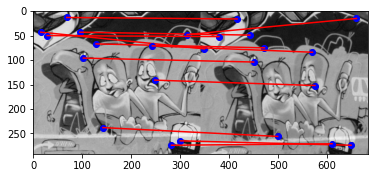

In [31]:
# the final algorithm
I1 = cv2.imread("data/graf/graf1_small.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_RGB2GRAY)
I1 = I1.astype("float32")
I2 = cv2.imread("data/graf/graf2_small.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY)
I2 = I2.astype("float32")
I2 = cv2.resize(I2, (I1.shape[1], I1.shape[0]))

_,_,Ixx1,Iyy1,Ixy1,_,_ = calculateOdvodi(I1,3)
_,_,Ixx2,Iyy2,Ixy2,_,_ = calculateOdvodi(I2,3)

hessian1 = hessianPoints(Ixx1,Iyy1,Ixy1,3)
hessian2 = hessianPoints(Ixx2,Iyy2,Ixy2,3)

hessian1copy = np.copy(hessian1)
hNonMax1,tocke1 = nonMax(hessian1copy,23000)
hessian2copy = np.copy(hessian2)
hNonMax2,tocke2 = nonMax(hessian2copy,23000)

desc1 = simple_descriptors(I1, tocke1)
desc2 = simple_descriptors(I2, tocke2)

hel,_,matches1 = find_correspondences(desc1,desc2)
hel,_,matches2 = find_correspondences(desc2,desc1)
bothMatched = []

#1. ker pri slikah ne dobimo enako stevilo tock, sta matches1 in 2 razlicnih dolzin. Zato loopamo cez krajso.
daljsi = 0
if matches1.shape[0] < matches2.shape[0]:
    krajsa = matches1.shape[0]
else:
    krajsa = matches2.shape[0]

#2. gledamo ce pri matches1 = [0 4] najdemo pri matches2 = [4 0]
for i in np.arange(krajsa):
    a = int(matches1[i,0])
    b = matches1[i,1]

    if (~np.isnan(b)): 
        b = int(b)
        if (matches2[b,1] == a):
            bothMatched.append([a,b])

display_matches(I1, I2, tocke1, tocke2, bothMatched)
